# Hedonic vs Utilitarian classification

pip install missingpy

## First: let us import necessary libraries and find file names

In [1]:
import numpy as np
import pandas as pd
import json 
from os import walk

from missingpy import MissForest

from sklearn.manifold import Isomap, TSNE, MDS, LocallyLinearEmbedding
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report

mypath='./reviews_features'
_, _, filenames = next(walk(mypath))
print(filenames)

['health.json', 'sports.json', 'groceries.json', 'pet.json', 'instruments.json', 'digital_music.json', 'movies.json', 'home.json', 'baby.json', 'tools.json', 'clothing.json', 'video.json', 'garden.json', 'toys.json', 'cds_vinyl.json', 'beauty.json', 'office.json', 'electronics.json', 'kindle.json', 'automotive.json', 'apps_android.json', 'books.json', 'games.json', 'mobile.json']


/home/pedro/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Lets import all the data files store in a DataFrame

In [ ]:
df = pd.DataFrame(
    columns=['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText','overall', 'summary', 'unixReviewTime', 'reviewTime', 'features','amazonCategory'],
)
for name in filenames:  
    temp = pd.read_json(mypath+'/'+name , lines =True)
    temp['amazonCategory'] = name[:-5]
    df = df.append( temp ,ignore_index=True)

**Note that we have stored the category itself in amazonCategory column**

In [ ]:
df.info()

**We don't have any problem reggarding nulls on our features**

In [ ]:
df.head()

In [ ]:
print(pd.unique(df.amazonCategory), len(pd.unique(df.amazonCategory)))

**We have taken and put all the categories correctly**

## Data visualizations: just an overview

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)

text = " ".join(review for review in df.loc[df.amazonCategory=='games'].reviewText)
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
text = " ".join(review for review in df.loc[df.amazonCategory=='tools'].reviewText)
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
text = " ".join(review for review in df.loc[df.amazonCategory=='clothing'].reviewText)
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
df.loc[df.amazonCategory=='games']['reviewText'][212119]

## Impute the categories we already know
### Intro

- Here we have an important note: 

    -> Q1 (quadrand 1) = utilitarian and not hedonic
    
    -> Q2 (quadrand 2) = utilitarian and hedonic
    
    -> Q3 (quadrand 3) = not utilitarian and not hedonic
    
    -> Q4 (quadrand 4) = not utilitarian and hedonic
    
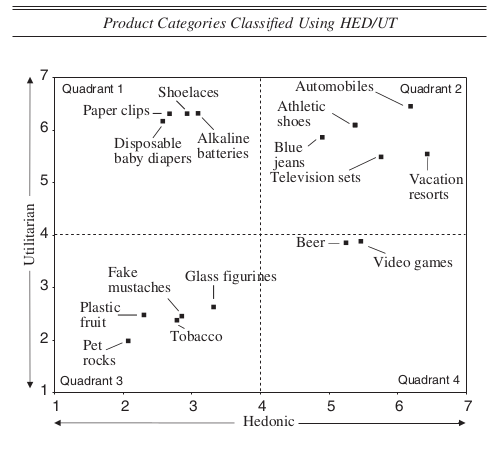

**Note that automobile and video games (Amazon) can be directly inputted in Q2 and Q4 respectively (paper)**

  Here we can identify other possible combinations like inside sports on amazon we will probably find athletic shoes and shoelaces, or inside of home we probably find television sets and glass figurines
  
  But we will have to take a look into each product's name to match them

### Import paper classes

In [ ]:
paper_table = pd.read_csv('JMR_paper_table.csv')
paper_table

### Inputting nans on our dataset target label

In [ ]:
df['class'] = np.nan

In [ ]:
df.info()

### Metadata import 
We found a problem here: the product's name is in the metadata and not with the reviews

Inside of metadata title there's the product's name. We will have to face a large problem to join the meta data into the dataset itself

In [ ]:
metaPath='./metadata'
_, _, files = next(walk(metaPath))
print(files)

In [ ]:
desired_columns= ['title', 'description', 'feature', 'asin']
clone = df.reset_index()
result = pd.DataFrame()

for file in files:
    with pd.read_json(metaPath+'/'+file, lines=True, chunksize=20000) as reader:
        reader
        for chunk in reader:
            chunk = chunk[desired_columns]
            temp = clone.merge(chunk, how='inner', on='asin')
            result = pd.concat([result, temp], ignore_index=True)
            print(result.info())

result.head()

In [ ]:
#meta = pd.read_json(metaPath+'/meta_All_Beauty.json', lines =True) # limit to 600mb  meta_AMAZON_FASHION.json
#meta = pd.read_json(metaPath+'/meta_AMAZON_FASHION.json', lines =True)
#desired_columns= ['title', 'description', 'feature', 'asin']
#meta = meta[desired_columns]
#meta.head()

In [ ]:
#clone = df
#clone = clone.set_index('asin')
#result = clone.merge(meta, how='left', on='asin', suffixes=('', '_y'),indicator=True)
#result.info()

In [ ]:
#result.groupby('_merge').size()

In [ ]:
#result.loc[~(result['_merge'] == 'right_only')].info()

In [ ]:
#result.title.fillna(result.title_y, inplace=True)
#result.description.fillna(result.description_y, inplace=True)
#result.feature.fillna(result.feature_y, inplace=True)

In [ ]:
#result.info()

In [ ]:
#result.drop( columns=['title_y', 'description_y', 'feature_y'], inplace=True)

In [ ]:
result.info()

In [ ]:
len(pd.unique(result['index']))

In [ ]:
df.info()

In [ ]:
#merged = df.merge(result, how='outer', on='asin')
#merged.info()

In [ ]:
len(pd.unique(df.reset_index().merge(result,how='outer',on='index', suffixes=['','_y'])['index']))

In [ ]:
x = df.reset_index().merge(result,how='outer',on='index', suffixes=['','_y']).drop_duplicates(subset='index')

In [ ]:
x.info()

In [ ]:
columns_drop=['reviewerID_y', 'asin_y', 'reviewerName_y', 'helpful_y', 'reviewText_y',
       'overall_y', 'summary_y', 'unixReviewTime_y', 'reviewTime_y', 'features_y',
       'amazonCategory_y', 'class_y']

In [ ]:
x.drop(columns=columns_drop,inplace=True)

In [ ]:
x.info()

### Impute known paper values

In [ ]:
x.loc[x.amazonCategory=='games','class'] = 'Q4'

In [ ]:
x.loc[x.amazonCategory=='games','class']

In [ ]:
x.loc[x.amazonCategory=='automotive','class'] = 'Q2'

In [ ]:
x.loc[x.amazonCategory=='automotive','class']

In [ ]:
x.info()

In [ ]:
19854/232748 *100

In [ ]:
x.loc[~x.title.isna()]['feature']

In [ ]:
paper_table.name.values

In [ ]:
x['feature']=x['feature'].fillna('').apply(' '.join)

In [ ]:
x['description']=x['description'].fillna('').apply(' '.join)

In [ ]:
len(x.loc[x.description.str.contains('athletic') & x.description.str.contains('shoe')])

In [ ]:
x.loc[x.description.str.contains('athletic') & x.description.str.contains('shoe'),'description'].values 
# they are not athletic shoes, they are only socks for sports (not the same=> do not make sense)

In [ ]:
len(x.loc[x.title.fillna('').str.contains('TV') | x.title.fillna('').str.contains('television')])

In [ ]:
pd.unique(x.loc[x.title.fillna('').str.contains('TV') | x.title.fillna('').str.contains('television'), 'title'].values)

In [ ]:
x.loc[x.title=='Sony KV-9PT50 9&quot; Trinitron TV','class'] = 'Q2'

In [ ]:
x.loc[x.title=='Sony KV-9PT50 9&quot; Trinitron TV','class']

In [ ]:
x.loc[x.description.fillna('').str.contains('diapers'), 'description'] ### this is diapers for dogs hahahah

In [ ]:
x.loc[x.description.fillna('').str.contains('batteries') & x.description.fillna('').str.contains('alkaline'), 'title']
# does not seam to be right 

In [ ]:
x.loc[x.title.fillna('').str.contains('paper') & x.title.fillna('').str.contains('clips'), 'title'].values

In [ ]:
pd.unique(x.loc[x.description.fillna('').str.contains('paper') & x.description.fillna('').str.contains('clips'), 'title'].values)

In [ ]:
x.loc[x.title=='ACCO Binder Clips, Mini, 1 Box, 12 Clips/Box (72010)','class'] = 'Q1'
x.loc[x.title=='ACCO Binder Clips, Mini, 1 Box, 12 Clips/Box (72010)','class']

In [ ]:
x.loc[x.title=='ACCO Paper Clips, Jumbo, Smooth, Economy, 10 Boxes, 100/Box (72580)','class'] = 'Q1'
x.loc[x.title=='ACCO Paper Clips, Jumbo, Smooth, Economy, 10 Boxes, 100/Box (72580)','class']

In [ ]:
x.loc[x.title=='OfficemateOIC Mini Binder Clips, Assorted Colors, 60 Clips per Tub (31024)','class'] = 'Q1'
x.loc[x.title=='OfficemateOIC Mini Binder Clips, Assorted Colors, 60 Clips per Tub (31024)','class']

In [ ]:
x.info()

### Prepare for imputation (cleaning & droppings)

In [ ]:
19918 / 232748 *100

In [ ]:
x.features

In [ ]:
len(x.features[1])

In [ ]:
#x.to_json('data_and_meta.json')

In [ ]:
l = x.features.tolist()

In [ ]:
data = pd.DataFrame(l,columns=[i for i in range(len(x.features[1]))])
data

In [ ]:
data['class'] = x['class'].reset_index().drop(columns='index')

In [ ]:
data.head()

In [ ]:
classes = data['class']

In [ ]:
#data.to_json('features_label.json')

In [ ]:
categorical = ['class']
numerical = []
X=data
X[categorical] = X[categorical].apply(lambda series: pd.Series(
    LabelEncoder().fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))


print(data)

#imp_num = IterativeImputer(estimator=RandomForestRegressor(),
#                           initial_strategy='mean',
#                           max_iter=10, random_state=0)

imp_cat = IterativeImputer(estimator=RandomForestClassifier(), 
                           initial_strategy='mean',
                           max_iter=30, random_state=42)

#data[numerical] = imp_num.fit_transform(data[numerical])
data[categorical] = imp_cat.fit_transform(data[categorical])

print(data)

In [ ]:
data.groupby('class').size()

In [ ]:
x.groupby('class').size()

In [ ]:
#categorical = ['class']
#imputer = MissForest()
#X= pd.DataFrame(l,columns=[i for i in range(len(x.features[1]))])
#X['class'] = x['class'].reset_index().drop(columns='index')

#X[categorical] = X[categorical].apply(lambda series: pd.Series(
#    LabelEncoder().fit_transform(series[series.notnull()]),
#    index=series[series.notnull()].index
#))

#X_imputed = imputer.fit_transform(X)
#X_imputed

In [2]:
df = pd.read_json('features_label.json')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232748 entries, 0 to 232747
Columns: 120 entries, 0 to class
dtypes: float64(118), int64(1), object(1)
memory usage: 214.9+ MB


In [3]:
#df.loc[~df['class'].isnull()]

In [4]:
df['class'] = df['class'].astype('category')

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,class
0,-0.098792,0.246780,0.372182,-0.267302,-0.093455,0.154483,-0.149150,0.133048,-0.161907,-0.061863,...,0.000803,0.799012,0.216770,0.488889,0.288604,2,0.977778,3.893833,0.022222,NaN
1,-0.073662,0.345128,0.301814,-0.476560,0.025313,0.079780,-0.086261,0.161001,-0.147534,0.065079,...,0.001706,0.643200,0.207359,0.480000,0.288444,1,1.000000,3.384134,0.000000,NaN
2,-0.239538,0.217312,0.391495,-0.259332,-0.096260,0.049797,-0.015582,0.133139,-0.179384,-0.108626,...,-0.001383,0.581315,0.272105,0.470588,0.288175,3,0.882353,3.008596,0.117647,NaN
3,-0.228471,0.270015,0.455785,-0.271271,0.050026,0.108745,-0.159302,0.216017,-0.107940,-0.053101,...,0.000455,0.698962,0.227270,0.470588,0.288175,1,1.000000,3.486968,0.000000,NaN
4,-0.174997,0.296510,0.258443,-0.317369,-0.158371,0.158997,-0.053249,0.170265,-0.081173,-0.090188,...,0.000666,0.896030,0.083818,0.478261,0.288402,1,1.000000,4.280255,0.000000,NaN


In [6]:
df.groupby('class').size()

class
Q1      59
Q2    9974
Q4    9885
dtype: int64

In [7]:
from sklearn import preprocessing
categorical = ['class']
le = preprocessing.LabelEncoder()
df[categorical] = df[categorical].apply(lambda series: pd.Series(
    le.fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))

In [ ]:
%%time

imputer = MissForest(random_state=42, class_weight='balanced')
imputed = imputer.fit_transform(df, cat_vars=119)
imputed

Iteration: 0
Iteration: 1


In [ ]:
cat_cols=['class']
imputed = pd.DataFrame(imputed, columns=df.columns.tolist())

imputed.describe(include='all')

In [ ]:
imputed.groupby('class').size()

In [11]:
metadata = pd.read_json('data_and_meta.json').reset_index()
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232748 entries, 0 to 232747
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   level_0         232748 non-null  int64 
 1   index           232748 non-null  int64 
 2   reviewerID      232748 non-null  object
 3   asin            232748 non-null  object
 4   reviewerName    230910 non-null  object
 5   helpful         232748 non-null  object
 6   reviewText      232748 non-null  object
 7   overall         232748 non-null  int64 
 8   summary         232748 non-null  object
 9   unixReviewTime  232748 non-null  int64 
 10  reviewTime      232748 non-null  object
 11  features        232748 non-null  object
 12  amazonCategory  232748 non-null  object
 13  class           19918 non-null   object
 14  title           106284 non-null  object
 15  description     232748 non-null  object
 16  feature         232748 non-null  object
dtypes: int64(4), object(13)
memor

In [ ]:
metadata['CLASS'] = imputed['class']
metadata.loc[~metadata.title.isnull() & (metadata.CLASS == 2)].iloc[100]

In [ ]:
metadata['CLASS'] = le.inverse_transform(imputed['class'].astype(int)[imputed['class'].notnull()])

In [18]:
metadata

,level_0,index,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,features,amazonCategory,class,title,description,feature,CLASS
0,0,0,A1JUPR7LPMYG1X,B00009V2QX,"Chef Kim ""My Review""","[0, 0]",Its time for me to purchase another box. great...,4,Great,1356739200,"12 29, 2012","[-0.0987924889, 0.24677984890000002, 0.3721822...",health,None,None,,,Q2
1,1,1,A6YT8ATZ4SEKT,B00009V2QX,C. Moran,"[0, 0]","Recieved OLD black and silver procell package,...",3,recieved OLD STOCK,1401840000,"06 4, 2014","[-0.07366212, 0.345128, 0.30181372, -0.4765604...",health,None,None,,,Q2
2,2,2,A0678500JUN3N7KUG4PS,B000056OWW,GigiS,"[0, 0]",The best cold sore remover product I've ever u...,5,Great product.,1403049600,"06 18, 2014","[-0.2395376471, 0.2173122941, 0.3914945765, -0...",health,None,None,,,Q2
3,3,3,A4DRGD09QEE9I,B00009V2QX,"C. R. Dyer ""home maker""","[0, 0]",If you've ever noticed your flashlights are di...,5,Batteries,1357516800,"01 7, 2013","[-0.2284705294, 0.2700145882, 0.45578470590000...",health,None,None,,,Q2
4,4,4,ABT4HGNR22RWO,B00009V2QX,Daniel L. Kellett Sr.,"[0, 0]",Received fast and as described. I have only u...,5,Big bang for your buck...,1320105600,"11 1, 2011","[-0.1749965652, 0.2965097391, 0.2584427783, -0...",health,None,None,,,Q2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232743,284526,232743,AGGAQLXPVGM5D,B002BDU7U2,Eagle Vision,"[13, 14]",WHAT COMES IN THE BOXCaseMicro USB CableInstru...,4,Very good case and battery with a limitation,1250467200,"08 17, 2009","[-0.1865138805, 0.0994569393, 0.39352668090000...",mobile,None,Mophie Juice Pack Air Case and Rechargeable Ba...,The Juice Pack Air is a rechargeable external ...,iPhone case and battery pack protects and adds...,Q2
232744,284527,232744,A261FJIRA4ELFV,B002BDU7U2,"Endi ""Endiablado""","[2, 2]","No wonder the price was so low, this battery p...",1,garbage,1301961600,"04 5, 2011","[-0.2122780702, 0.177555193, 0.390302733300000...",mobile,None,Mophie Juice Pack Air Case and Rechargeable Ba...,The Juice Pack Air is a rechargeable external ...,iPhone case and battery pack protects and adds...,Q2
232745,284528,232745,AR0XBJRF01FFK,B002BDU7U2,ewang,"[2, 2]","I bought this almost 2 years ago honestly, and...",5,Good backup charger!,1391990400,"02 10, 2014","[-0.1162860196, 0.2957332569, 0.4044825294, -0...",mobile,None,Mophie Juice Pack Air Case and Rechargeable Ba...,The Juice Pack Air is a rechargeable external ...,iPhone case and battery pack protects and adds...,Q2
232746,284529,232746,A1UE2O203AAMEJ,B002BDU7U2,G. Jones,"[0, 2]",I bought this originally for the outrageous pr...,1,Barely works,1283990400,"09 9, 2010","[-0.0930763855, 0.1452266367, 0.37296447860000...",mobile,None,Mophie Juice Pack Air Case and Rechargeable Ba...,The Juice Pack Air is a rechargeable external ...,iPhone case and battery pack protects and adds...,Q2
